# Getting started with stitchee's Harmony service-chain

This Jupyter notebook demonstrates how to use the "Harmony Subsetter with Multi-dimensional Concatenator", a Harmony backend service chain that transforms level 2 data into a merged output product. This notebook will use harmony-py and a variety of input arguments that can be given to the service to define the output.

## The "Harmony Subsetter with Multi-dimensional Concatenator"

This service chain operates by executing four sequential steps:
1. **Performing subsetting on each file**
    - Uses L2-Subsetter
    - Performed in parallel for each file
3. **Identifying which data files should be grouped together for subsequent concatenation operations**
    - Uses Batchee
    - A single operation
4. **Concatenating data files, by "extending" one of the arrays' existing dimensions**
    - Uses STICHEE
    - Performed in parallel for each batch identified in the previous step
5. **Concatenating the results of the previous step along a new dimension**
    - Uses CONCISE
    - A single operation, but performed in parallel if file size limit is exceeded

The following GIF illustrates the above-mentioned steps 3 and 4:
![ExtendAndStackGIF](concat_extend_and_stack.gif "extend and stack gif")

In [1]:
import os
import datetime as dt

import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from metpy.plots import USCOUNTIES

from harmony import BBox, Client, Collection, Request, Environment, CapabilitiesRequest
from IPython.display import JSON

## Define plotting functions

In [2]:
def get_XYC(filepath, product_name, index=-1):
    ds_root = xr.open_dataset(filepath)
    ds_product = xr.open_dataset(filepath, group="product")
    ds_geo = xr.open_dataset(filepath, group="geolocation")

    if index < 0:
        X, Y, C = ds_geo.longitude.values, ds_geo.latitude.values, ds_product[product_name].values
        filename = filepath
    else:
        X, Y, C = (
            ds_geo.longitude[index].values,
            ds_geo.latitude[index].values,
            ds_product[product_name][index].values,
        )
        filename = ds_root.subset_files.data[index]
    inds = np.logical_not(np.isnan(X) | np.isnan(Y) | np.isnan(C))

    return filename, X[inds], Y[inds], C[inds]


def plot_map(ax, h2d, extent: list = [-140, -15, 15, 65]):
    proj = ccrs.PlateCarree()
    cmp = plt.cm.nipy_spectral_r

    ax.set_extent(extent, crs=proj)

    ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.1, edgecolor="dimgray")
    ax.add_feature(cfeature.OCEAN, linewidth=0.1, edgecolor="dimgray", facecolor="lightsteelblue")
    ax.add_feature(cfeature.LAKES, linewidth=0.1, edgecolor="dimgray", facecolor="lightsteelblue")
    ax.add_feature(cfeature.BORDERS, linewidth=0.1, edgecolor="dimgray")
    ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=0.1, edgecolor="dimgray")

    (H, xbins, ybins) = h2d
    H = H.T
    ax.pcolormesh(xbins, ybins, H, norm="log", cmap=cmp, alpha=0.8)
    return ax

#### Authentication: Before we can use the service we need to initialize a Harmony `Client` object, which requires an account with NASA Earthdata Login (EDL)

In [3]:
harmony_client = Client(env=Environment.UAT)

# Examining the current Harmony capabilities for a TEMPO collection

Notice the new service chain, defined here as "l2-subsetter-batchee-stitchee-concise"

In [4]:
capabilities_request = CapabilitiesRequest(collection_id="C1254854453-LARC_CLOUD")
capabilities = harmony_client.submit(capabilities_request)

JSON(capabilities, expanded=True)

<IPython.core.display.JSON object>

## Building "Harmony Subsetter with Multi-dimensional Concatenator" requests

The Harmony Subsetter with Multi-dimensional Concatenator can allow a user to make requests that specify several parameters, such as:

- The data dimension along which intermediate steps will concatenate ("`extend`")
- The target temporal range for subsetting ("`temporal`")
- The target spatial domain for subsetting ("`spatial`")
- The target variables for subsetting ("`variables`")

# How to form and submit a request to L2SS-B-S-C chain

#### Define functions for downloading results of a Harmony job and for plotting

In [5]:
def download_harmony_results(jobid: str) -> list:
    output_files = []

    for url in harmony_client.result_urls(jobid):
        step_id, filename = url.split("/")[-2:]

        os.makedirs(f"uat/{jobid}/{step_id}", exist_ok=True)

        future = harmony_client.download(url, directory=f"uat/{jobid}/{step_id}")
        output_files.append(future.result())

    return output_files

In [6]:
def plot_map_histogram2d(files: list, extent: list = [-140, -15, 15, 65]) -> None:
    proj = ccrs.PlateCarree()
    XYCs = [get_XYC(fn, "vertical_column_total") for fn in files]

    fig, axs = plt.subplots(
        figsize=(8, 6.5),
        dpi=300,
        facecolor="w",
        subplot_kw=dict(projection=proj),
        linewidth=8,
        edgecolor="white",
        layout="compressed",
    )
    h2d = np.histogram2d(
        np.concatenate([xx for ff, xx, yy, cc in XYCs]),
        np.concatenate([yy for ff, xx, yy, cc in XYCs]),
        weights=np.concatenate([cc for ff, xx, yy, cc in XYCs]),
        bins=100,
    )

    ax = plot_map(axs, h2d, extent)

### Specify the collection to make requests against

This is a $NO_2$ column data product from the Tropospheric Emissions Monitoring of Pollution (TEMPO) instrument, with this [CMR entry in UAT](https://cmr.uat.earthdata.nasa.gov/search/concepts/C1254854453-LARC_CLOUD.html).

In [7]:
collection = Collection(id="C1254854453-LARC_CLOUD")

### Request example #1: Concatenate with Temporal subsetting

In [8]:
request = Request(
    collection=collection,
    temporal={
        "start": dt.datetime(2024, 1, 23, 21, 27, 0),
        "stop": dt.datetime(2024, 1, 23, 21, 40, 0),
    },
    extend="mirror_step",
)
assert request.is_valid()

job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [10]:
data = harmony_client.status(job_id)
JSON(data)

<IPython.core.display.JSON object>

In [11]:
files_list = download_harmony_results(job_id)

uat/b6bb61d7-e7a7-4b9f-9017-23d153e93e44/4028567/C1254854453-LARC_CLOUD_merged.nc4
uat/a83a2bb4-e890-44a9-b39a-c8c40080c6a5/4028621/C1254854453-LARC_CLOUD_merged.nc4
uat/65e258be-8340-401c-94b6-c4e2eedbc8a9/4028628/C1254854453-LARC_CLOUD_merged.nc4


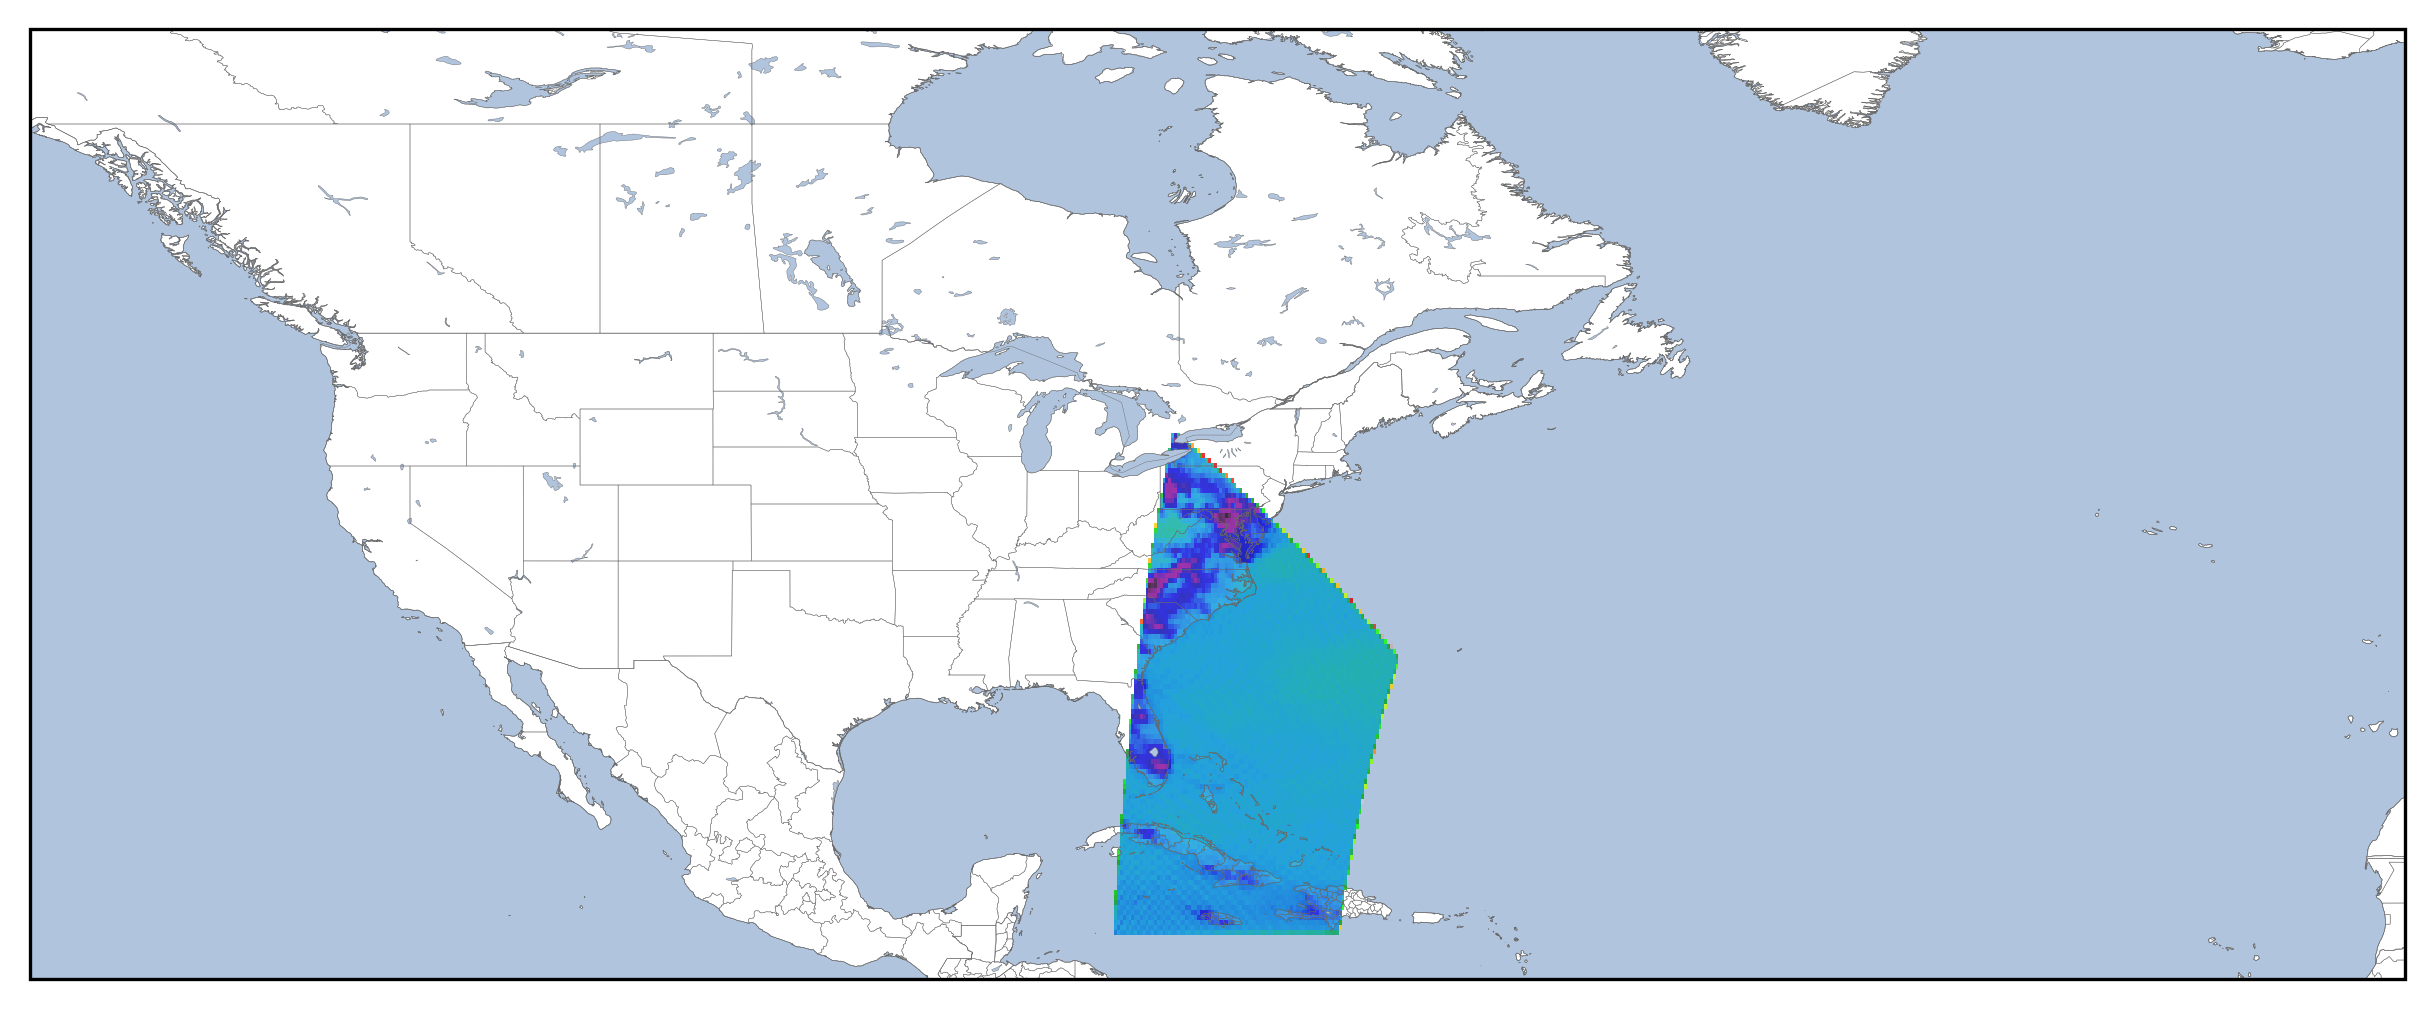

In [12]:
plot_map_histogram2d(files_list)

### Request example #2: Concatenate with Temporal and Spatial subsetting

In [13]:
request = Request(collection=collection, spatial=BBox(-100, 30, -90, 40), extend="mirror_step")
assert request.is_valid()

job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [14]:
files_list = download_harmony_results(job_id)

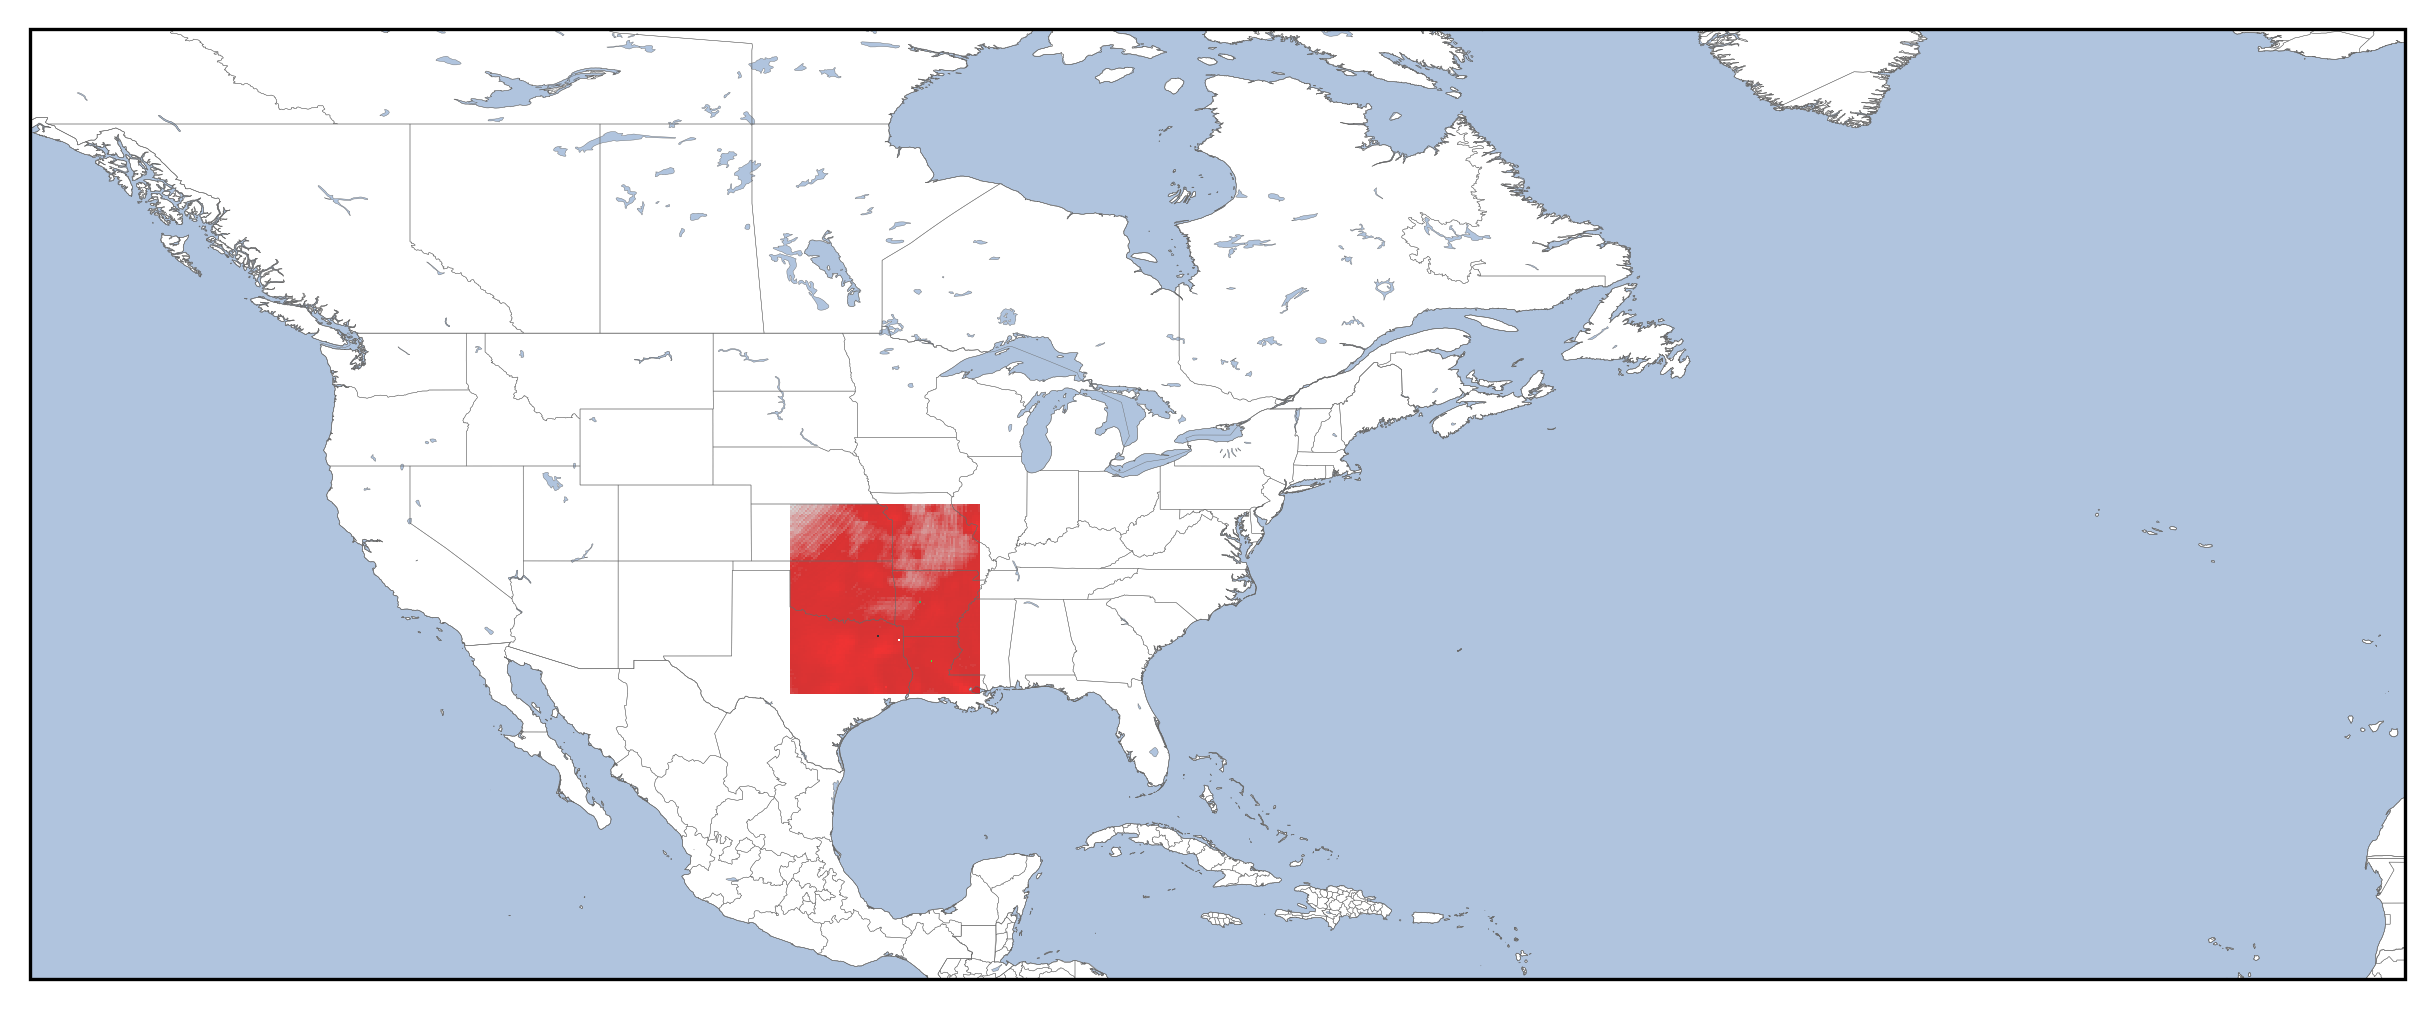

In [15]:
plot_map_histogram2d(files_list)

### Request example #3: Concatenate with Temporal, Spatial, and Variable subsetting

In [16]:
request = Request(
    collection=collection,
    variables=["/product/vertical_column_total"],
    spatial=BBox(-100, 30, -90, 40),
    temporal={
        "start": dt.datetime(2024, 1, 23, 13, 26, 58),
        "stop": dt.datetime(2024, 1, 23, 13, 33, 34),
    },
    extend="mirror_step",
)
assert request.is_valid()

job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [17]:
files_list = download_harmony_results(job_id)

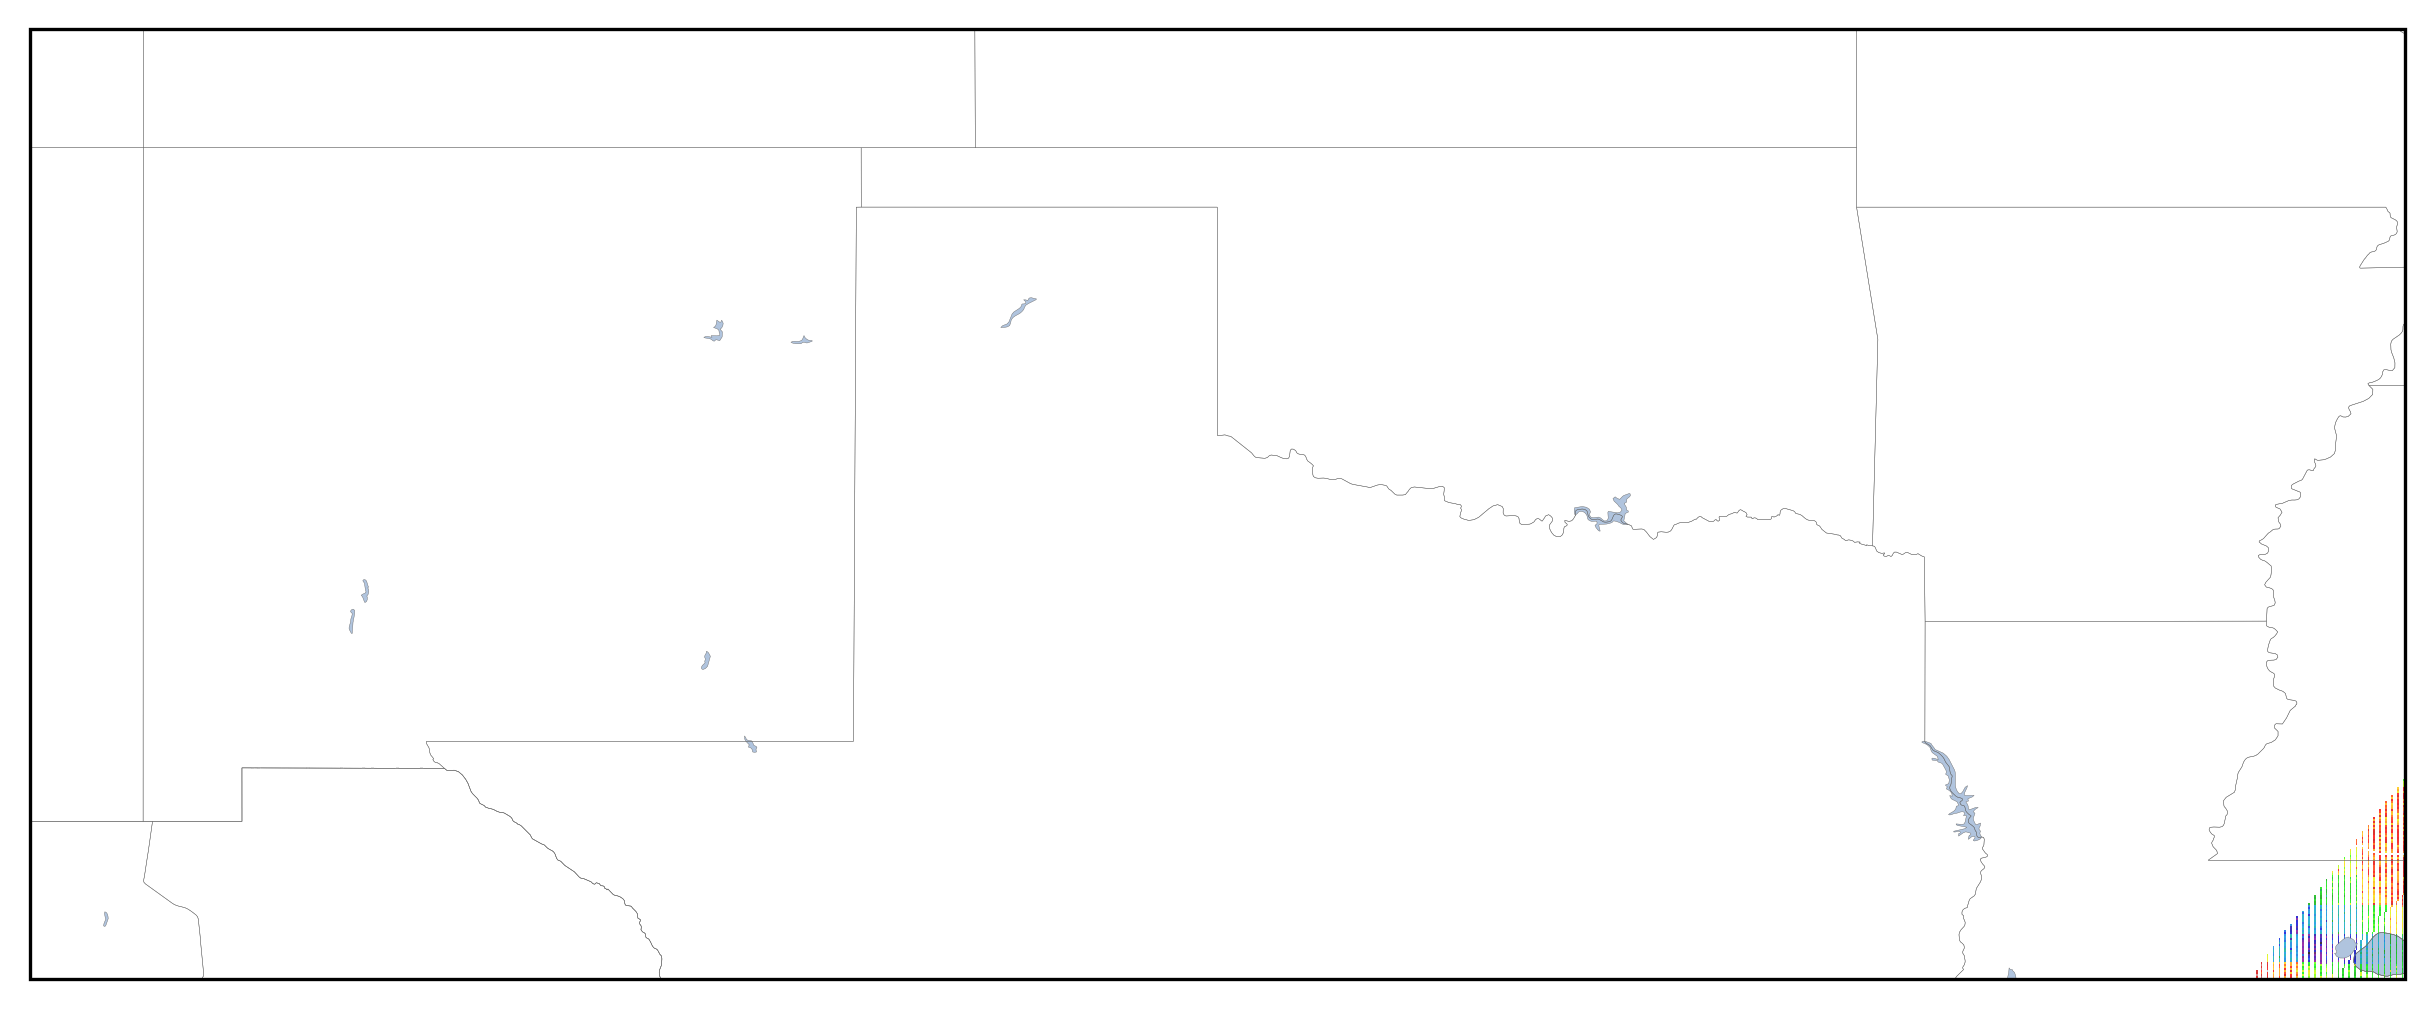

In [20]:
plot_map_histogram2d(files_list, extent=[-110, -90, 30, 38])

END of Notebook.